<br><left><b><font size=4>Section 4 – Language Models exploration<b><left>

- Loading Libraries and Dataset
### Import Libraries: Import essential libraries such as 
- pandas for data manipulation. 
- matplotlib.pyplot used for creating static visualizations in Python.
- MultiLabelBinarizer: This is used to transform between iterable of iterables and a multilabel format. It is useful for handling multilabel classification tasks.
- classification_report: A function that builds a text report showing the main classification metrics, useful for evaluating the performance of a classification model.
- gensim.models.doc2vec.Doc2Vec: An implementation of the Doc2Vec algorithm, which is used to generate document embeddings.
- gensim.models.doc2vec.TaggedDocument: Used to tag documents with IDs, which is useful when training a Doc2Vec model.
- keras.models.Sequential: A linear stack of layers used to create neural networks in Keras.
- keras.layers.Dense: A fully connected neural network layer.
- keras.layers.InputLayer: A Keras layer used as the input layer to a model.

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report


#Language Models Exploration 
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from keras.models import Sequential
from keras.layers import Dense, InputLayer
import tensorflow as tf

In [14]:
if not os.path.isfile("ssh_attacks_decoded_splitted.parquet"):
    raise Exception("You should run the preprocessing file")
df = pd.read_parquet("ssh_attacks_decoded_splitted.parquet")

In [15]:
%run "train_test_split_sampled.ipynb"
df_sampled = sampling(df)

##### Building and Training Doc2Vec Model

- Constants for train-test split and training

In [17]:
train_size = 0.5
random_state = 42
epochs = 10

In [18]:
# Splitting dataset into features (X) and target (y) variables
X = df_sampled[["session_id","full_session"]]
y = df_sampled["Set_Fingerprint"]

# Perform train-test split on the dataset
X_train, X_test, y_train, y_test = split_train_test(X, y, train_size=train_size, random_state=random_state)

# Tagging the training and testing data for Doc2Vec model
tagged_data_train = [TaggedDocument(words=session, tags=[str(session_id)]) for session_id, session in zip(X_train["session_id"], X_train["full_session"])]
tagged_data_test = [TaggedDocument(words=session, tags=[str(session_id)]) for session_id, session in zip(X_test["session_id"], X_test["full_session"])]

#### Function to train a Doc2Vec model
#### This function initializes, builds the vocabulary, and trains the Doc2Vec model using the training data

In [19]:
def train_doc2vec_model(vector_size=100, epochs=10):
    doc2vec_model = Doc2Vec(vector_size=vector_size, epochs=epochs, seed = 42, workers=1)
    doc2vec_model.build_vocab(tagged_data_train)
    doc2vec_model.train(tagged_data_train, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)
    return doc2vec_model

#### Function to create a neural network model using Keras
#### This function sets up a sequential model with an input layer, one hidden layer, and an output layer

In [20]:
def create_model(vector_size, learning_rate):
    hidden_layers_neurons = int(vector_size * 2/3) + 7 
    model = Sequential()
    model.add(InputLayer(input_shape=(vector_size,))) # Input layer with the size of vector embeddings
    model.add(Dense(hidden_layers_neurons, activation=tf.nn.relu)) # Hidden layer with ReLU activation
    model.add(Dense(7, activation=tf.nn.sigmoid)) # Output layer with sigmoid activation for multi-label classification
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate) # Adam optimizer with specified learning rate
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=["accuracy"]) # Compile the model with binary cross-entropy loss and accuracy metrics
    return model

#### Function to train and evaluate the neural network model
#### This function trains the model on the training data and evaluates it on the testing data, printing metrics and visualizing the loss

In [21]:

def train_and_evaluate(X_train, X_test, y_train, y_test, vector_size, learning_rate, epochs=10):
    model = create_model(vector_size, learning_rate)

    mlb = MultiLabelBinarizer()
    y_train_mlb = mlb.fit_transform(y_train)
    y_test_mlb = mlb.transform(y_test)

    X_train_tensor = tf.convert_to_tensor(X_train)
    X_test_tensor = tf.convert_to_tensor(X_test)
    y_train_tensor = tf.convert_to_tensor(y_train_mlb)
    y_test_tensor = tf.convert_to_tensor(y_test_mlb)
    
    print(f"Training the model (Vector Size: {vector_size}, Learning Rate: {vector_size})")
    history = model.fit(X_train_tensor, y_train_tensor, batch_size=64, validation_data=(X_test_tensor, y_test_tensor), epochs=epochs, verbose=0)

    loss_test, accuracy_test = model.evaluate(X_test_tensor, y_test_tensor, verbose=0)
    print("Loss on test set:", loss_test)
    print("Accuracy on test set:", accuracy_test)
    
    plt.plot(history.history['loss'], label=f'Training Loss (LR={learning_rate})')
    plt.plot(history.history['val_loss'], label=f'Validation Loss (LR={learning_rate})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss (Vector Size: {vector_size})')
    plt.legend()
    plt.show()
    
    # Classification report for test set
    y_test_prob = model.predict(X_test_tensor)
    y_test_pred = (y_test_prob >= 0.5).astype(int)
    report_test = classification_report(y_test_mlb, y_test_pred, target_names=mlb.classes_)
    print(f"Classification Report on Test Set (Vector Size: {vector_size})")
    print(report_test)

    # Classification report for train set
    y_train_prob = model.predict(X_train_tensor)
    y_train_pred = (y_train_prob >= 0.5).astype(int)
    report_train = classification_report(y_train_mlb, y_train_pred, target_names=mlb.classes_)
    print(f"Classification Report on Train Set (Vector Size: {vector_size})")
    print(report_train)


#### Define the range of vector sizes and learning rates to explore

In [22]:
vector_sizes = [100, 300, 800]
learning_rates = [0.1, 0.01, 0.001]

Training the model (Vector Size: 100, Learning Rate: 100)
Loss on test set: 0.04561970382928848
Accuracy on test set: 0.8957977294921875


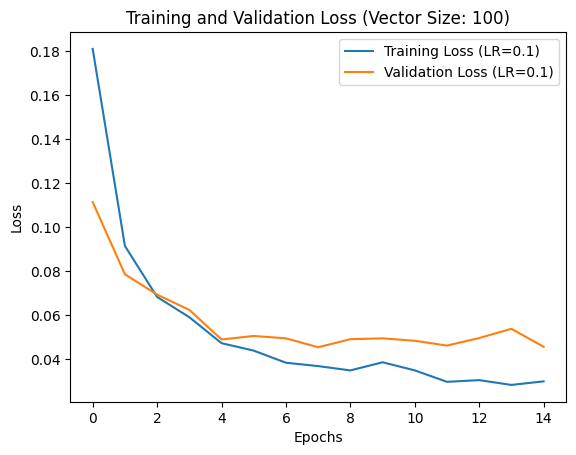

92/92 [==============================] - 0s 2ms/step
Classification Report on Test Set (Vector Size: 100)
                 precision    recall  f1-score   support

Defense Evasion       0.89      0.94      0.91       239
      Discovery       1.00      1.00      1.00      2908
      Execution       0.98      0.93      0.95      1170
       Harmless       0.67      0.06      0.11        34
         Impact       0.00      0.00      0.00         7
          Other       1.00      0.50      0.67         8
    Persistence       0.99      0.99      0.99      2645

      micro avg       0.99      0.98      0.98      7011
      macro avg       0.79      0.63      0.66      7011
   weighted avg       0.98      0.98      0.98      7011
    samples avg       0.99      0.98      0.98      7011

23/92 [======>.......................] - ETA: 0s

c:\Users\loren\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


92/92 [==============================] - 0s 4ms/step
Classification Report on Train Set (Vector Size: 100)
                 precision    recall  f1-score   support

Defense Evasion       0.96      0.97      0.97       239
      Discovery       1.00      1.00      1.00      2907
      Execution       0.99      0.97      0.98      1170
       Harmless       1.00      0.17      0.29        35
         Impact       1.00      0.29      0.44         7
          Other       1.00      0.89      0.94         9
    Persistence       1.00      1.00      1.00      2646

      micro avg       0.99      0.99      0.99      7013
      macro avg       0.99      0.76      0.80      7013
   weighted avg       0.99      0.99      0.99      7013
    samples avg       0.99      0.99      0.99      7013

Training the model (Vector Size: 100, Learning Rate: 100)


c:\Users\loren\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Loss on test set: 0.04864351823925972
Accuracy on test set: 0.7335155606269836


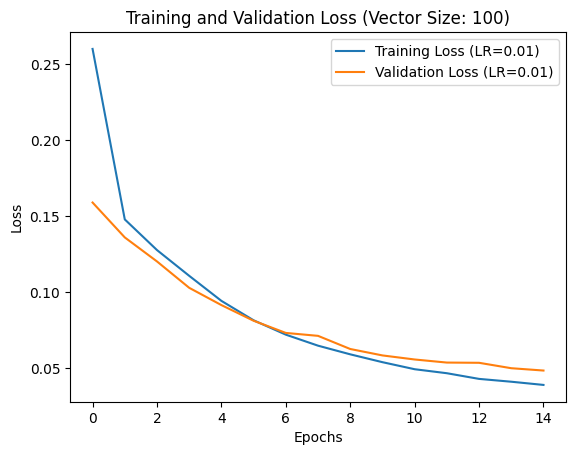

92/92 [==============================] - 0s 1ms/step
Classification Report on Test Set (Vector Size: 100)
                 precision    recall  f1-score   support

Defense Evasion       0.94      0.90      0.92       239
      Discovery       1.00      1.00      1.00      2908
      Execution       0.96      0.95      0.95      1170
       Harmless       1.00      0.09      0.16        34
         Impact       0.50      0.14      0.22         7
          Other       0.75      0.38      0.50         8
    Persistence       0.98      1.00      0.99      2645

      micro avg       0.98      0.98      0.98      7011
      macro avg       0.88      0.63      0.68      7011
   weighted avg       0.98      0.98      0.98      7011
    samples avg       0.98      0.98      0.98      7011

92/92 [==============================] - 0s 1ms/step


c:\Users\loren\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report on Train Set (Vector Size: 100)
                 precision    recall  f1-score   support

Defense Evasion       0.99      0.92      0.95       239
      Discovery       1.00      1.00      1.00      2907
      Execution       0.97      0.97      0.97      1170
       Harmless       1.00      0.06      0.11        35
         Impact       1.00      0.43      0.60         7
          Other       1.00      0.33      0.50         9
    Persistence       0.98      1.00      0.99      2646

      micro avg       0.99      0.99      0.99      7013
      macro avg       0.99      0.67      0.73      7013
   weighted avg       0.99      0.99      0.98      7013
    samples avg       0.99      0.99      0.98      7013

Training the model (Vector Size: 100, Learning Rate: 100)
Loss on test set: 0.12316570430994034
Accuracy on test set: 0.9101468920707703


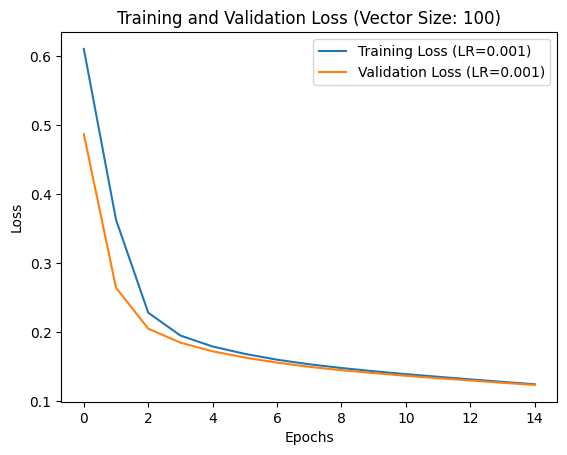

92/92 [==============================] - 0s 1ms/step
Classification Report on Test Set (Vector Size: 100)
                 precision    recall  f1-score   support

Defense Evasion       0.30      0.01      0.02       239
      Discovery       0.99      1.00      1.00      2908
      Execution       0.88      0.86      0.87      1170
       Harmless       0.50      0.03      0.06        34
         Impact       0.00      0.00      0.00         7
          Other       0.00      0.00      0.00         8
    Persistence       0.91      1.00      0.95      2645

      micro avg       0.94      0.93      0.94      7011
      macro avg       0.51      0.41      0.41      7011
   weighted avg       0.91      0.93      0.92      7011
    samples avg       0.94      0.93      0.93      7011

34/92 [==========>...................] - ETA: 0s

c:\Users\loren\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


92/92 [==============================] - 0s 2ms/step
Classification Report on Train Set (Vector Size: 100)
                 precision    recall  f1-score   support

Defense Evasion       0.43      0.01      0.02       239
      Discovery       0.99      1.00      1.00      2907
      Execution       0.88      0.86      0.87      1170
       Harmless       1.00      0.03      0.06        35
         Impact       0.00      0.00      0.00         7
          Other       0.00      0.00      0.00         9
    Persistence       0.91      1.00      0.95      2646

      micro avg       0.94      0.94      0.94      7013
      macro avg       0.60      0.41      0.41      7013
   weighted avg       0.92      0.94      0.92      7013
    samples avg       0.94      0.93      0.93      7013



c:\Users\loren\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training the model (Vector Size: 300, Learning Rate: 300)
Loss on test set: 0.07167365401983261
Accuracy on test set: 0.8865732550621033


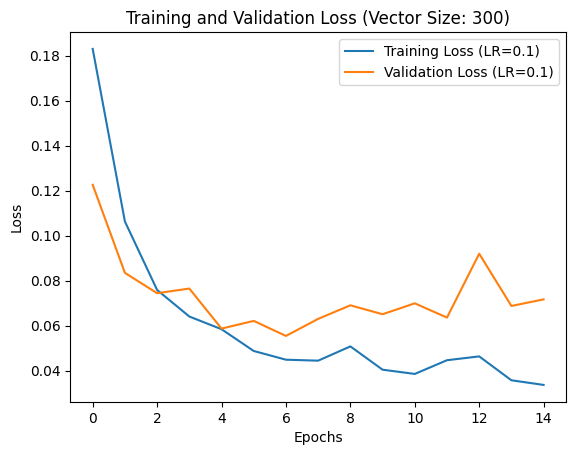

92/92 [==============================] - 0s 2ms/step
Classification Report on Test Set (Vector Size: 300)
                 precision    recall  f1-score   support

Defense Evasion       0.92      0.92      0.92       239
      Discovery       1.00      1.00      1.00      2908
      Execution       0.92      0.97      0.94      1170
       Harmless       0.67      0.12      0.20        34
         Impact       0.00      0.00      0.00         7
          Other       0.67      0.50      0.57         8
    Persistence       0.98      0.99      0.99      2645

      micro avg       0.98      0.98      0.98      7011
      macro avg       0.74      0.64      0.66      7011
   weighted avg       0.97      0.98      0.98      7011
    samples avg       0.98      0.98      0.98      7011

 1/92 [..............................] - ETA: 1s

c:\Users\loren\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\loren\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


92/92 [==============================] - 0s 2ms/step
Classification Report on Train Set (Vector Size: 300)
                 precision    recall  f1-score   support

Defense Evasion       0.97      0.96      0.96       239
      Discovery       1.00      1.00      1.00      2907
      Execution       0.93      0.98      0.96      1170
       Harmless       1.00      0.20      0.33        35
         Impact       1.00      0.29      0.44         7
          Other       0.83      0.56      0.67         9
    Persistence       0.99      1.00      0.99      2646

      micro avg       0.98      0.99      0.99      7013
      macro avg       0.96      0.71      0.77      7013
   weighted avg       0.98      0.99      0.98      7013
    samples avg       0.98      0.99      0.98      7013

Training the model (Vector Size: 300, Learning Rate: 300)


c:\Users\loren\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Loss on test set: 0.04478403553366661
Accuracy on test set: 0.8097027540206909


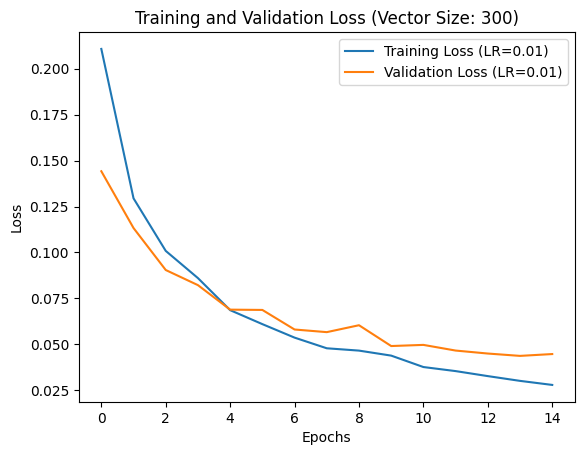

92/92 [==============================] - 0s 2ms/step
Classification Report on Test Set (Vector Size: 300)
                 precision    recall  f1-score   support

Defense Evasion       0.91      0.92      0.92       239
      Discovery       1.00      1.00      1.00      2908
      Execution       0.97      0.95      0.96      1170
       Harmless       0.71      0.15      0.24        34
         Impact       0.50      0.14      0.22         7
          Other       1.00      0.62      0.77         8
    Persistence       0.99      0.99      0.99      2645

      micro avg       0.99      0.98      0.98      7011
      macro avg       0.87      0.68      0.73      7011
   weighted avg       0.99      0.98      0.98      7011
    samples avg       0.98      0.98      0.98      7011

54/92 [================>.............] - ETA: 0s

c:\Users\loren\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


92/92 [==============================] - 0s 2ms/step
Classification Report on Train Set (Vector Size: 300)
                 precision    recall  f1-score   support

Defense Evasion       0.97      0.97      0.97       239
      Discovery       1.00      1.00      1.00      2907
      Execution       0.98      0.98      0.98      1170
       Harmless       1.00      0.17      0.29        35
         Impact       0.80      0.57      0.67         7
          Other       1.00      0.78      0.88         9
    Persistence       0.99      1.00      0.99      2646

      micro avg       0.99      0.99      0.99      7013
      macro avg       0.96      0.78      0.83      7013
   weighted avg       0.99      0.99      0.99      7013
    samples avg       0.99      0.99      0.99      7013

Training the model (Vector Size: 300, Learning Rate: 300)


c:\Users\loren\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Loss on test set: 0.09971912205219269
Accuracy on test set: 0.8995558619499207


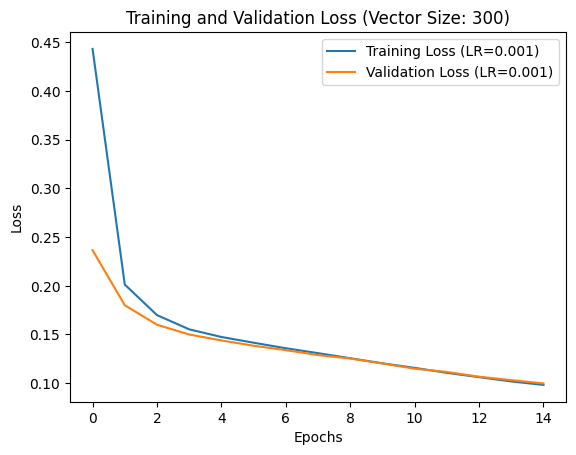

92/92 [==============================] - 0s 2ms/step
Classification Report on Test Set (Vector Size: 300)
                 precision    recall  f1-score   support

Defense Evasion       0.84      0.33      0.47       239
      Discovery       0.99      1.00      1.00      2908
      Execution       0.91      0.88      0.90      1170
       Harmless       1.00      0.03      0.06        34
         Impact       0.00      0.00      0.00         7
          Other       0.00      0.00      0.00         8
    Persistence       0.93      0.99      0.96      2645

      micro avg       0.95      0.95      0.95      7011
      macro avg       0.67      0.46      0.48      7011
   weighted avg       0.95      0.95      0.94      7011
    samples avg       0.96      0.95      0.95      7011

48/92 [==============>...............] - ETA: 0s

c:\Users\loren\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


92/92 [==============================] - 0s 3ms/step
Classification Report on Train Set (Vector Size: 300)
                 precision    recall  f1-score   support

Defense Evasion       0.93      0.30      0.45       239
      Discovery       0.99      1.00      1.00      2907
      Execution       0.92      0.89      0.90      1170
       Harmless       1.00      0.06      0.11        35
         Impact       0.00      0.00      0.00         7
          Other       0.00      0.00      0.00         9
    Persistence       0.93      0.99      0.96      2646

      micro avg       0.96      0.95      0.95      7013
      macro avg       0.68      0.46      0.49      7013
   weighted avg       0.95      0.95      0.94      7013
    samples avg       0.96      0.95      0.95      7013



c:\Users\loren\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training the model (Vector Size: 800, Learning Rate: 800)
Loss on test set: 0.08655671030282974
Accuracy on test set: 0.914929986000061


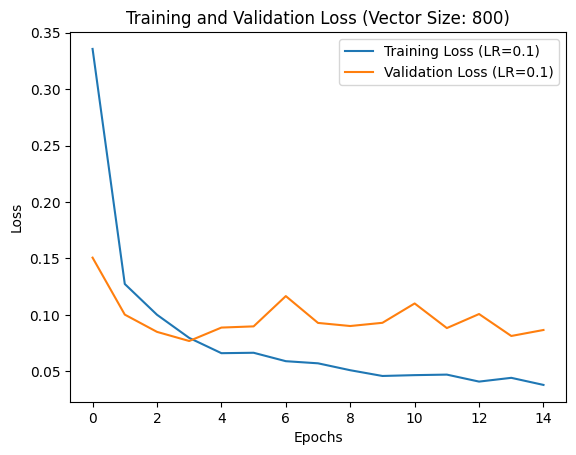

92/92 [==============================] - 0s 3ms/step
Classification Report on Test Set (Vector Size: 800)
                 precision    recall  f1-score   support

Defense Evasion       0.89      0.91      0.90       239
      Discovery       1.00      1.00      1.00      2908
      Execution       0.94      0.95      0.95      1170
       Harmless       0.33      0.09      0.14        34
         Impact       0.00      0.00      0.00         7
          Other       0.31      0.62      0.42         8
    Persistence       0.98      0.98      0.98      2645

      micro avg       0.98      0.98      0.98      7011
      macro avg       0.64      0.65      0.63      7011
   weighted avg       0.97      0.98      0.97      7011
    samples avg       0.98      0.98      0.97      7011

50/92 [===============>..............] - ETA: 0s

c:\Users\loren\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


92/92 [==============================] - 0s 2ms/step
Classification Report on Train Set (Vector Size: 800)
                 precision    recall  f1-score   support

Defense Evasion       0.95      0.94      0.94       239
      Discovery       1.00      1.00      1.00      2907
      Execution       0.96      0.98      0.97      1170
       Harmless       1.00      0.23      0.37        35
         Impact       1.00      0.29      0.44         7
          Other       0.53      0.89      0.67         9
    Persistence       0.99      0.99      0.99      2646

      micro avg       0.98      0.99      0.99      7013
      macro avg       0.92      0.76      0.77      7013
   weighted avg       0.98      0.99      0.98      7013
    samples avg       0.98      0.99      0.98      7013

Training the model (Vector Size: 800, Learning Rate: 800)
Loss on test set: 0.05239586532115936
Accuracy on test set: 0.8633413314819336


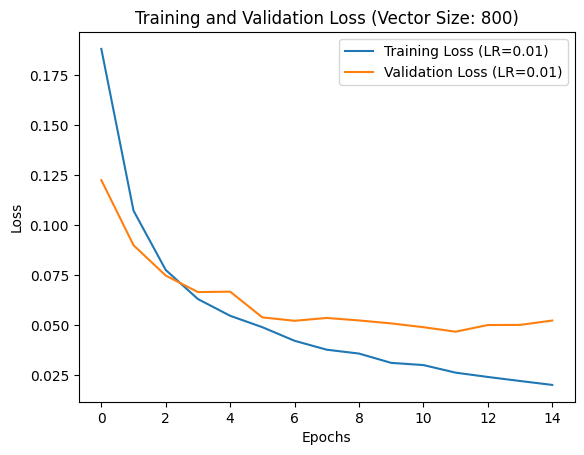

92/92 [==============================] - 0s 2ms/step
Classification Report on Test Set (Vector Size: 800)
                 precision    recall  f1-score   support

Defense Evasion       0.81      0.96      0.88       239
      Discovery       1.00      1.00      1.00      2908
      Execution       0.98      0.94      0.96      1170
       Harmless       0.86      0.18      0.29        34
         Impact       1.00      0.14      0.25         7
          Other       1.00      0.75      0.86         8
    Persistence       0.99      0.98      0.99      2645

      micro avg       0.98      0.98      0.98      7011
      macro avg       0.95      0.71      0.75      7011
   weighted avg       0.98      0.98      0.98      7011
    samples avg       0.98      0.98      0.98      7011

43/92 [=============>................] - ETA: 0s

c:\Users\loren\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


92/92 [==============================] - 0s 2ms/step
Classification Report on Train Set (Vector Size: 800)
                 precision    recall  f1-score   support

Defense Evasion       0.94      0.99      0.97       239
      Discovery       1.00      1.00      1.00      2907
      Execution       1.00      0.99      0.99      1170
       Harmless       1.00      0.26      0.41        35
         Impact       1.00      0.57      0.73         7
          Other       1.00      1.00      1.00         9
    Persistence       1.00      0.99      0.99      2646

      micro avg       1.00      0.99      0.99      7013
      macro avg       0.99      0.83      0.87      7013
   weighted avg       1.00      0.99      0.99      7013
    samples avg       0.99      0.99      0.99      7013



c:\Users\loren\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training the model (Vector Size: 800, Learning Rate: 800)
Loss on test set: 0.07532999664545059
Accuracy on test set: 0.8472838997840881


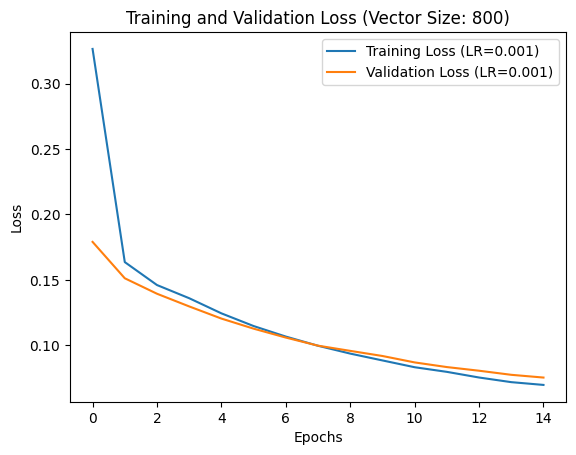

92/92 [==============================] - 0s 2ms/step
Classification Report on Test Set (Vector Size: 800)
                 precision    recall  f1-score   support

Defense Evasion       0.90      0.59      0.71       239
      Discovery       0.99      1.00      1.00      2908
      Execution       0.94      0.90      0.92      1170
       Harmless       1.00      0.09      0.16        34
         Impact       0.00      0.00      0.00         7
          Other       0.00      0.00      0.00         8
    Persistence       0.96      1.00      0.98      2645

      micro avg       0.97      0.96      0.97      7011
      macro avg       0.69      0.51      0.54      7011
   weighted avg       0.97      0.96      0.96      7011
    samples avg       0.97      0.96      0.96      7011

23/92 [======>.......................] - ETA: 0s

c:\Users\loren\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


92/92 [==============================] - 0s 2ms/step
Classification Report on Train Set (Vector Size: 800)
                 precision    recall  f1-score   support

Defense Evasion       0.96      0.64      0.77       239
      Discovery       0.99      1.00      1.00      2907
      Execution       0.95      0.92      0.94      1170
       Harmless       1.00      0.06      0.11        35
         Impact       1.00      0.14      0.25         7
          Other       0.00      0.00      0.00         9
    Persistence       0.96      1.00      0.98      2646

      micro avg       0.97      0.97      0.97      7013
      macro avg       0.84      0.54      0.58      7013
   weighted avg       0.97      0.97      0.97      7013
    samples avg       0.97      0.97      0.97      7013



c:\Users\loren\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
# Loop over each vector size
for vector_size in vector_sizes:
    doc2vec_model = train_doc2vec_model(vector_size=vector_size, epochs=10)
    X_train_doc2vec = [doc2vec_model.infer_vector(document) for document in X_train["full_session"]]
    X_test_doc2vec = [doc2vec_model.infer_vector(document) for document in X_test["full_session"]]

    # Loop over each learning rate
    for learning_rate in learning_rates:
        train_and_evaluate(X_train_doc2vec, X_test_doc2vec, y_train, y_test, vector_size, learning_rate, 15)